In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


In [2]:
# Constants
ALPHA = 0.1                 # Learning rate
EPSILON = 0.1               # Exploration rate
GAMMA = 1.0                 # Discount factor
NUM_EPISODES = 300          # Number of episodes per run
NUM_RUNS = 10000            # Number of runs to average over
MEAN_REWARD = -0.1          # Mean reward from state B
VARIANCE_REWARD = 1.0       # Variance of reward from state B
NUM_ACTIONS_B = 10          # Number of possible actions from state B


In [3]:
class Environment:
    """
    The Environment class handles state transitions and reward generation.
    """

    def __init__(self):
        pass

    def step(self, state, action):
        """
        Take a step in the MDP.

        Parameters:
            state (str): Current state ('A' or 'B').
            action (int): Action taken.

        Returns:
            next_state (str or None): Next state ('A', 'B', or None for terminal).
            reward (float): Reward received.
        """
        if state == 'A':
            if action == 0:  # Left action
                next_state = 'B'
                reward = 0.0
            elif action == 1:  # Right action
                next_state = None  # Terminal state
                reward = 0.0
        elif state == 'B':
            next_state = None  # Terminal state
            reward = np.random.normal(MEAN_REWARD, np.sqrt(VARIANCE_REWARD))
        else:
            next_state = None
            reward = 0.0
        return next_state, reward


In [4]:
class Agent:
    """
    The Agent class handles action selection and learning.
    """

    def __init__(self, algorithm='Q', seed=None):
        """
        Initialize the agent.

        Parameters:
            algorithm (str): 'Q' for Q-learning, 'DoubleQ' for Double Q-learning.
            seed (int): Seed for random number generator.
        """
        if seed is not None:
            np.random.seed(seed)
        self.algorithm = algorithm
        self.epsilon = EPSILON
        self.alpha = ALPHA
        self.gamma = GAMMA

        if algorithm == 'Q':
            # Initialize Q-values
            self.q_values = {
                'A': np.zeros(2),              # Actions: Left (0), Right (1)
                'B': np.zeros(NUM_ACTIONS_B)   # Actions from state B
            }
        elif algorithm == 'DoubleQ':
            # Initialize Q1 and Q2 values
            self.q1_values = {
                'A': np.zeros(2),
                'B': np.zeros(NUM_ACTIONS_B)
            }
            self.q2_values = {
                'A': np.zeros(2),
                'B': np.zeros(NUM_ACTIONS_B)
            }

    def choose_action(self, state):
        """
        Choose an action using an ε-greedy policy.

        Parameters:
            state (str): Current state.

        Returns:
            action (int): Action chosen.
        """
        if np.random.rand() < self.epsilon:
            # Random action
            if state == 'A':
                action = np.random.choice([0, 1])  # Left or Right
            elif state == 'B':
                action = np.random.randint(NUM_ACTIONS_B)
        else:
            # Greedy action with random tie-breaking
            if self.algorithm == 'Q':
                q_s = self.q_values[state]
            elif self.algorithm == 'DoubleQ':
                q_s = self.q1_values[state] + self.q2_values[state]
            max_value = np.max(q_s)
            greedy_actions = np.flatnonzero(q_s == max_value)
            action = np.random.choice(greedy_actions)
        return action

    def learn(self, state, action, reward, next_state):
        """
        Update the agent's knowledge based on the observed transition.

        Parameters:
            state (str): Current state.
            action (int): Action taken.
            reward (float): Reward received.
            next_state (str or None): Next state observed.
        """
        if self.algorithm == 'Q':
            # Q-learning update
            if next_state is not None:
                max_q_next = np.max(self.q_values[next_state])
            else:
                max_q_next = 0.0  # Terminal state
            self.q_values[state][action] += self.alpha * (
                reward + self.gamma * max_q_next - self.q_values[state][action]
            )
        elif self.algorithm == 'DoubleQ':
            # Double Q-learning update
            if np.random.rand() < 0.5:
                if next_state is not None:
                    next_action = np.argmax(self.q1_values[next_state])
                    target = self.q2_values[next_state][next_action]
                else:
                    target = 0.0
                self.q1_values[state][action] += self.alpha * (
                    reward + self.gamma * target - self.q1_values[state][action]
                )
            else:
                if next_state is not None:
                    next_action = np.argmax(self.q2_values[next_state])
                    target = self.q1_values[next_state][next_action]
                else:
                    target = 0.0
                self.q2_values[state][action] += self.alpha * (
                    reward + self.gamma * target - self.q2_values[state][action]
                )


In [5]:
def run_episode(agent, env):
    """
    Run a single episode for the given agent and environment.

    Parameters:
        agent (Agent): The agent.
        env (Environment): The environment.

    Returns:
        left_action (int): 1 if left action was taken from state A, else 0.
    """
    state = 'A'
    action = agent.choose_action(state)
    left_action = int(action == 0)  # Record if left action was chosen
    next_state, reward = env.step(state, action)
    agent.learn(state, action, reward, next_state)

    # Handle transition from B if necessary
    if next_state == 'B':
        state = next_state
        action = agent.choose_action(state)
        next_state, reward = env.step(state, action)
        agent.learn(state, action, reward, next_state)
    return left_action


In [6]:
def run_experiment(seed=None):
    """
    Runs a single experiment of Q-learning and Double Q-learning.

    Parameters:
        seed (int): Seed for random number generator.

    Returns:
        left_counts_q (np.array): Left action counts for Q-learning.
        left_counts_double_q (np.array): Left action counts for Double Q-learning.
    """
    # Initialize environment
    env_q = Environment()
    env_double_q = Environment()

    # Initialize agents
    agent_q = Agent(algorithm='Q', seed=seed)
    agent_double_q = Agent(algorithm='DoubleQ', seed=seed)

    left_counts_q = np.zeros(NUM_EPISODES)
    left_counts_double_q = np.zeros(NUM_EPISODES)

    # Run episodes for Q-learning agent
    for episode in range(NUM_EPISODES):
        left_action = run_episode(agent_q, env_q)
        left_counts_q[episode] = left_action

    # Run episodes for Double Q-learning agent
    for episode in range(NUM_EPISODES):
        left_action = run_episode(agent_double_q, env_double_q)
        left_counts_double_q[episode] = left_action

    return left_counts_q, left_counts_double_q


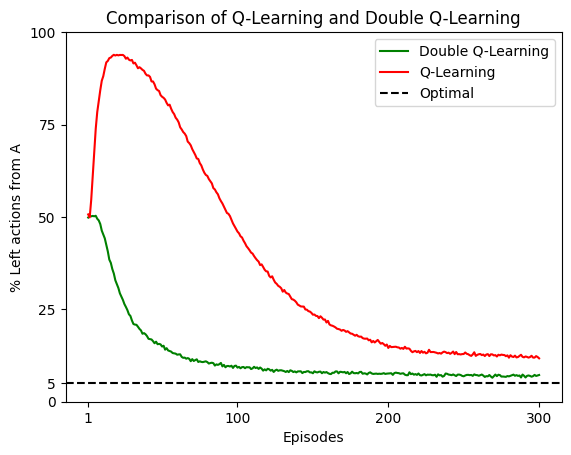

In [7]:
def main():
    """
    Main function to run the experiments and plot the results.
    """
    # Generate random seeds for each run to ensure different random sequences
    seeds = np.random.randint(0, 2**32 - 1, size=NUM_RUNS)

    # Run experiments in parallel using joblib
    results = Parallel(n_jobs=-1)(
        delayed(run_experiment)(seed) for seed in seeds
    )

    # Initialize arrays to accumulate results
    left_action_counts_q = np.zeros(NUM_EPISODES)
    left_action_counts_double_q = np.zeros(NUM_EPISODES)

    # Sum the results from all runs
    for left_counts_q, left_counts_double_q in results:
        left_action_counts_q += left_counts_q
        left_action_counts_double_q += left_counts_double_q

    # Calculate percentages
    percent_left_actions_q = left_action_counts_q / NUM_RUNS * 100
    percent_left_actions_double_q = left_action_counts_double_q / NUM_RUNS * 100

    # Plot results
    episodes = np.arange(1, NUM_EPISODES + 1)
    plt.figure()
    plt.plot(episodes, percent_left_actions_double_q, color='green', label='Double Q-Learning')
    plt.plot(episodes, percent_left_actions_q, color='red', label='Q-Learning')
    plt.axhline(y=EPSILON / 2 * 100, color='black', linestyle='dashed', label='Optimal')
    plt.xlabel('Episodes')
    plt.ylabel('% Left actions from A')
    plt.title('Comparison of Q-Learning and Double Q-Learning')
    plt.legend()
    plt.xticks([1, 100, 200, 300])
    plt.yticks([0, 5, 25, 50, 75, 100])
    plt.show()

if __name__ == '__main__':
    main()
